In [1]:
import pandas as pd
import numpy as np 
import cvxopt
from cvxopt import solvers
from cvxopt import matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm as SVM
import seaborn as sn

In [2]:
train_data = pd.read_csv("train.csv", usecols = np.linspace(0,8,9,dtype=int)).to_numpy()
train_label = pd.read_csv("train.csv", usecols = [9]).to_numpy()

test_data = pd.read_csv("test.csv", usecols = np.linspace(0,8,9,dtype=int)).to_numpy()
test_label = pd.read_csv("test.csv", usecols = [9]).to_numpy()

In [3]:
print(train_data.shape)
print(test_data.shape)

(253440, 9)
(63360, 9)


In [4]:
253440 + 63360

316800

In [24]:
for i in range(train_label.shape[0]):
    if train_label[i][0] != 0:
        train_label[i][0] = 1
    else:
        train_label[i][0] = -1

for i in range(test_label.shape[0]):
    if test_label[i][0] != 0:
        test_label[i][0] = 1
    else:
        test_label[i][0] = -1

Since for $\forall 1 \leq i \leq m $, where $m$ is the number of data points, our primal objective function with kernel and slack variables is
\begin{align*}
\min _{w, b, \xi} & \frac{1}{2} w^Tw+C \sum_{i=1}^{m} \xi_{i} \\
\text { s.t.}\quad  & y_{i}\left(w^{\top} x_{i}+b\right) \geq 1-\xi_{i} \\
& \xi_{i} \geq 0
\end{align*}

For an optimization problem of CVXOPT, we need the formation
\begin{align*}
\min _{x} & \frac{1}{2} x^{T} P x+q^{T} x \\
\text { s.t.}\quad  & G x \leq h
\end{align*}

So, denote $m$ as the number of data points and $n$ as the number of dimensions, we could construct the required matrices as
\begin{align*}
P_1 &= \left[\begin{array}{cc}
0 & 0 \\
0 & I_n
\end{array}\right]\in \mathbb{R}^{n+1}\times \mathbb{R}^{n+1}\\
P &= \left[\begin{array}{cc}
P_1 & 0_{(n+1) \times m} \\
0_{m\times (n+1)} & 0_{m\times m}
\end{array}\right] \in \mathbb{R}^{m+n+1}\times \mathbb{R}^{m+n+1}\\
q &= \left[0,\dots,0,C,\dots,C\right] \in 1\times \mathbb{R}^{m+n+1}\\
G_1^{(i)} &= -y^{(i)} x^{(i)}, \text { where } x^{(i)} \text { represents the } \left[1 \mid i^{th} \text { row of the data matrix}\right]\\
G &= \left[\begin{array}{cc}
G_1 & - I_{m} \\
0_{m \times (n+1)} & -I_{m}
\end{array}\right] \\
h &= [-1, \ldots,-1,0, \ldots, 0] \text{ with m -1's and m 0's}
\end{align*}
So, after we solve the quadratic program, we have $b = x_0$ and $w = x_{1:n}$

In [5]:
def rbf(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

class binary_SVM:
    
    def __init__(self, kernel, C):
        self.kernel = kernel
        self.C = C
        
    def fit(self, train_data, train_label):
        """
        Train SVM (primal form)

        Argument:
            train_data: N*D matrix, each row as a sample and each column as a feature
            train_label: N*1 vector, each row as a label
            C: tradeoff parameter (on slack variable side)

        Return:
            w: feature vector (column vector)
            b: bias term
        """
        m, n = train_data.shape
        
        P_1 = np.identity(n + 1)
        P_1[0, 0] = 0
        
    
        tmp_1 = np.zeros((n + 1, m))
        tmp_2 = np.zeros((m, n + 1))
        tmp_3 = np.zeros((m, m))
    
        P_u = np.concatenate((P_1,tmp_1),axis = 1)
        P_d = np.concatenate((tmp_2,tmp_3),axis = 1)
    
        P = matrix(np.concatenate((P_u,P_d), axis = 0))
        q = matrix(np.array([0.] * (n + 1) + [self.C] * m).reshape(-1,1))
    
        train_with_leading = np.pad(train_data, pad_width=((0, 0), (1, 0)), constant_values=1)
        G_1 = -train_label * train_with_leading
        tmp_4 = -np.identity(m)
        tmp_5 = np.zeros((m, n + 1))
        G_u = np.concatenate((G_1,tmp_4),axis = 1)
        G_d = np.concatenate((tmp_5,tmp_4),axis = 1)
        G = matrix(np.concatenate((G_u,G_d), axis = 0))
    
        h = matrix(np.array([-1.] * m + [0] * m).reshape(-1,1))
    
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h)['x']
    
        self.w = np.array(solution[1:len(solution) - m])
        self.b = solution[0]


    def predict(self, test_data, test_label):
        """
        Test linear SVM

        Argument:
            test_data: M*D matrix, each row as a sample and each column as a feature
            test_label: M*1 vector, each row as a label
            w: feature vector
            b: bias term

        Return:
            test_accuracy: a float between [0, 1] representing the test accuracy
        """
        m,n = test_data.shape
        res = []
        pred = np.dot(test_data, self.w) + self.b
        for i in range(m):
            test = pred[i] * test_label[i]
            res.append(test)
        
        correct = len([i for i in res if i > 0])
        test_accuracy = correct / m
    
        return test_accuracy, pred

### fit model and use test data to test the model

In [25]:
svm = binary_SVM(kernel = rbf, C = 1)
svm.fit(train_data[0:5000], train_label[0:5000])

In [26]:
n_test = 5000
test_accuracy, pred = svm.predict(test_data[0:n_test], test_label[0:n_test])
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.7572


### plot the confusion matrix

<AxesSubplot:>

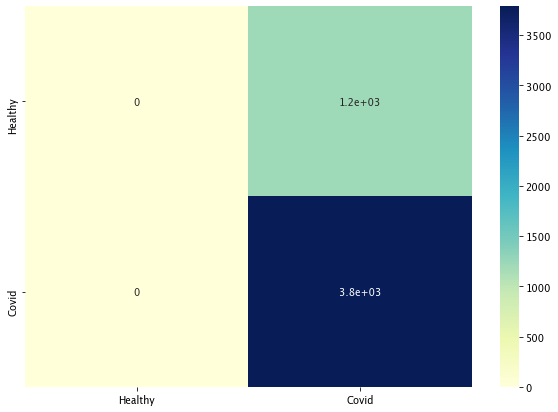

In [30]:
conf_matrix = confusion_matrix(y_true = test_label[0:n_test].reshape(-1,), y_pred=np.round(pred.reshape(-1,)))
df_cmt = pd.DataFrame(conf_matrix, index = ['Healthy', 'Covid'], columns = ['Healthy', 'Covid'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cmt, annot=True, cmap="YlGnBu")

### plot roc curve 

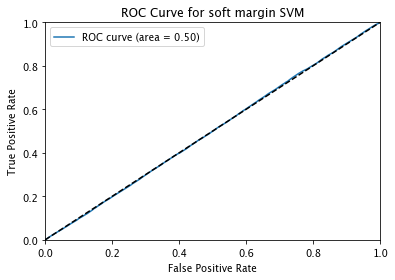

In [59]:
classifier = SVM.SVC(kernel='rbf', probability=True, C=10)
classifier.fit(train_data[0:5000], train_label[0:5000].ravel())
probas_ = classifier.predict_proba(test_data[0:n_test])

fpr, tpr, thresholds = roc_curve(test_label[0:n_test], probas_[:, 1])
roc_auc = auc(fpr, tpr)

plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for soft margin SVM')
plt.legend(loc="upper left")
plt.show()

### Confusion matrix and ROC Curve for logistic regression

In [40]:
for i in range(train_label.shape[0]):
    if train_label[i][0] != -1:
        train_label[i][0] = 1
    else:
        train_label[i][0] = 0

for i in range(test_label.shape[0]):
    if test_label[i][0] != -1:
        test_label[i][0] = 1
    else:
        test_label[i][0] = 0

<AxesSubplot:>

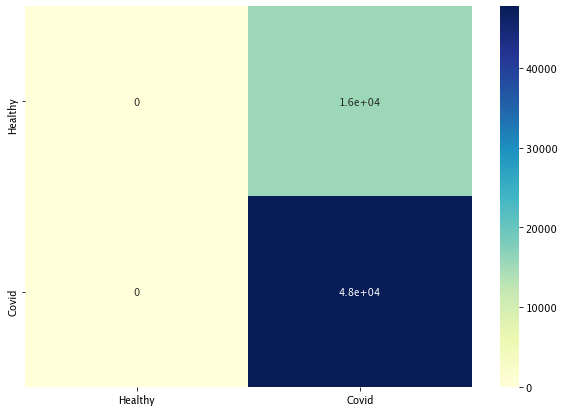

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sn


n_test = test_data.shape[0]

lr = LogisticRegression(penalty='l2', C=10)
lr.fit(train_data, train_label.ravel())

preds = lr.predict(test_data)
conf_matrix = confusion_matrix(y_true = test_label.reshape(-1,), y_pred = preds)
df_cmt = pd.DataFrame(conf_matrix, index = ['Healthy', 'Covid'], columns = ['Healthy', 'Covid'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cmt, annot=True, cmap="YlGnBu")

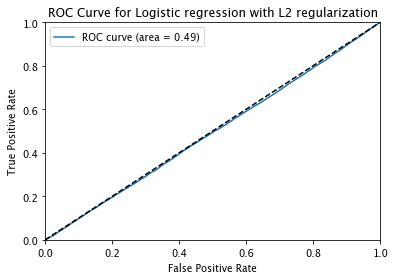

In [55]:
probas = lr.predict_proba(test_data[0:n_test])[:, 1]
fpr, tpr, thresholds = roc_curve(test_label[0:n_test], probas)
roc_auc = auc(fpr, tpr)

plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic regression with L2 regularization')
plt.legend(loc="upper left")
plt.show()

### ROC Curve for Decision tree

<AxesSubplot:>

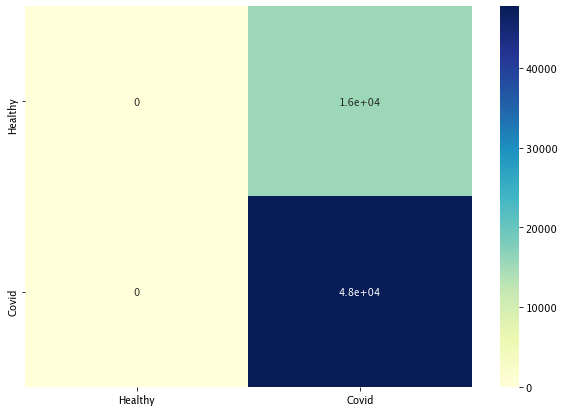

In [57]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(train_data, train_label.ravel())
preds = model.predict(test_data)
conf_matrix = confusion_matrix(y_true = test_label.reshape(-1,), y_pred = preds)
df_cmt = pd.DataFrame(conf_matrix, index = ['Healthy', 'Covid'], columns = ['Healthy', 'Covid'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cmt, annot=True, cmap="YlGnBu")

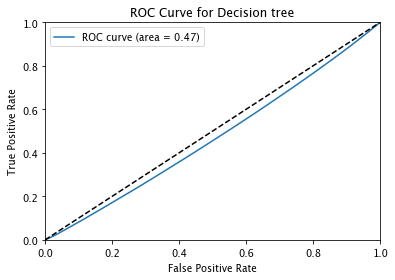

In [60]:
probas = model.predict_proba(test_data)[:, 1]

fpr, tpr, thresholds = roc_curve(test_label, probas)
roc_auc = auc(fpr, tpr)

plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision tree')
plt.legend(loc="upper left")
plt.show()